# <center>Data Pre-Processing</center>

## 0. Importing Libraries

In [1]:
!python --version

import warnings
warnings.filterwarnings('ignore')

Python 3.6.10 :: Anaconda, Inc.


In [3]:
import cv2     
import math   
import matplotlib.pyplot as plt    
import pandas as pd
import numpy as np 
from os import path
from PIL import Image as img

%matplotlib inline

## 1. Loading and combining play datasets

In [90]:
videos_csv = pd.read_csv('../data/play_data/Video.csv',sep=';')
plays_csv = pd.read_csv('../data/play_data/Play.csv',sep=';')
training_labels = pd.merge(plays_csv.iloc[:,[0,1,2,3,4,5,9,10]], videos_csv[['VideoFileName','VideoPath','PlayID','GameID']],left_on='ID', right_on='PlayID')
training_labels = training_labels[training_labels.Type.isin(['K', 'R', 'P', 'X', 'F', 'U'])]
training_labels.head()

,ID,Down,ToGo,Spot,Text,Quarter,HasBall,Type,VideoFileName,VideoPath,PlayID,GameID
0,11,2.0,3,H24,"2nd & 3 at OSU24: Saine, Brandon rush for 11 y...",1,V,R,000,2009/G3/Q1/,11,3
1,11,2.0,3,H24,"2nd & 3 at OSU24: Saine, Brandon rush for 11 y...",1,V,R,003,2009/G3/Q1/,11,3
2,15,1.0,0,H03,"1st & GOAL at OSU03: Pettrey, Aaron kick attem...",1,V,X,002,2009/G3/Q1/,15,3
3,18,1.0,10,H26,"1st & 10 at OSU26: Masoli, J. pass complete to...",1,H,P,012,2009/G4/Q1/,18,4
4,38,1.0,10,H09,"1st & 10 at OSU09: James, L. rush for loss of ...",1,H,R,027,2009/G4/Q1/,38,4


## 2 Splitting videos into static frames

In [94]:
label_dict = {}
for index, row in training_labels.iterrows():
    video_path = '../data/videos_high_resolution/' + row[9] + 'raw/' + row[8] + '.mp4'
    label = row[7]
    if index % 1000 == 0 or index == (len(training_labels) - 1):
        print("Video " + str(index + 1) + " of " + str(len(training_labels)))
    if path.exists(video_path):
        cap = cv2.VideoCapture(video_path)
        frameRate = cap.get(cv2.CAP_PROP_FPS)
        x = 1
        count = 0
        while(cap.isOpened()):
            frameId = cap.get(cv2.CAP_PROP_POS_FRAMES)
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0) or (frameId % math.floor(frameRate) == (math.floor(frameRate) // 2)):
                filename ="../data/training_frames/" + str(row[-1]) + "_" + str(row[5]) + "_" + row[8] + "_" + "frame%d.jpg" % count
                count+=1
                h, w, c = frame.shape
                y = (w-h)//2
                good = frame[:, y:y+h]
                good = cv2.resize(good,(224,224))
                cv2.imwrite(filename, good)
                label_dict[filename] = [str(row[-1]) + "_" + str(row[5]) + "_" + row[8], count, label]
        cap.release()

Video 1 of 6370
Video 1001 of 6370
Video 2001 of 6370
Video 3001 of 6370
Video 4001 of 6370
Video 5001 of 6370
Video 6001 of 6370
Video 6370 of 6370


## 3. Saving the training frames' labels

In [95]:
label_map = {
    'K': 0,
    'R': 1,
    'P': 2,
    'X': 3,
    'F': 4,
    'U': 5,
}

labels_df = pd.DataFrame.from_dict(label_dict, orient='index')
labels_df.reset_index(level=0, inplace=True)
labels_df.columns = ['filename','play','frame','label']
labels_df['filename'] = labels_df['filename'].str[24:]
labels_df['numeric_label'] = labels_df['label'].map(label_map)

labels_df.to_csv('../data/training_labels/labels.csv', index=False)

In [3]:
labels_df = pd.read_csv('../data/training_labels/labels.csv')
labels_df

,filename,play,frame,label,numeric_label
0,264_1_000_frame0.jpg,264_1_000,1,K,0
1,264_1_000_frame1.jpg,264_1_000,2,K,0
2,264_1_000_frame2.jpg,264_1_000,3,K,0
3,264_1_000_frame3.jpg,264_1_000,4,K,0
4,264_1_000_frame4.jpg,264_1_000,5,K,0
...,...,...,...,...,...
134305,6017_4_039_frame16.jpg,6017_4_039,17,P,2
134306,6017_4_039_frame17.jpg,6017_4_039,18,P,2
134307,6017_4_039_frame18.jpg,6017_4_039,19,P,2
134308,6017_4_039_frame19.jpg,6017_4_039,20,P,2


## 4. Creating a numpy array with all the frames for each play

In [4]:
path = "../data/training_frames/"
images =  [[]]
prev_play = labels_df.play[0]
play_idx = 0
plays = [labels_df.iloc[0].play]
labels = [labels_df.iloc[0].numeric_label]
char_labels = [labels_df.iloc[0].label]

for idx, row in labels_df.iterrows():
    image = img.open(path + row.filename)
    if prev_play != row.play:
        images[play_idx] = np.asarray(images[play_idx])
        play_idx += 1
        prev_play = row.play
        images.append([])
        labels.append(row.numeric_label)
        char_labels.append(row.label)
        plays.append(row.play)
        if play_idx % 1000 == 0 or play_idx == (5667 - 1):
            print("Video " + str(play_idx + 1) + " of " + str(5667))
    images[play_idx].append(np.asarray(image))
    
images[-1] = np.asarray(images[-1])    
images = np.asarray(images)

Video 1001 of 5661
Video 2001 of 5661
Video 3001 of 5661
Video 4001 of 5661
Video 5001 of 5661
Video 5661 of 5661


In [10]:
print(images.shape)
print(images[0].shape)
print(images[0][0].shape)

(5667,)
(32, 224, 224, 3)
(224, 224, 3)


In [11]:
print(len(labels))
print(len(char_labels))
print(len(plays))

5667
5667
5667


In [111]:
# Saving the numeric labels

np.save('../data/numpy_data/numeric_labels.npy', labels)

# Saving the char labels

np.save('../data/numpy_data/char_labels.npy', char_labels)

# Saving the play numbers

np.save('../data/numpy_data/plays.npy', plays)

In [9]:
# Saving the numpy array containing all the frames for each play

np.save('../data/numpy_data/images.npy', images)

## 5. Converting the training labels to one-hot vectors

In [12]:
one_hot_labels = np.zeros((len(labels),len(labels_df.numeric_label.unique())))
idx = 0

for label in labels:
    one_hot_labels[idx][label] = 1
    idx += 1
    
one_hot_labels = np.asarray(one_hot_labels)

In [13]:
# Saving the numpy array containing all the labels as one-hot encoded vectors

np.save('../data/numpy_data/one_hot_labels.npy', one_hot_labels)

## 6. Creating a smaller training data set with randomly sampled plays

In [14]:
# Random Indexes
indexes = np.random.choice(len(images), size=(len(images) // 5), replace=False)

# Images Array
samples_images = images[indexes]

# One-hot Labels
samples_labels = one_hot_labels[indexes]

display(samples_images.shape)
display(samples_labels.shape)

(1133,)

(1133, 6)

In [15]:
# Saving the numpy arrays containing samples of the images and labels

np.save('../data/numpy_data/sample_indexes.npy', indexes)
np.save('../data/numpy_data/sample_images.npy', samples_images)
np.save('../data/numpy_data/sample_one_hot_labels.npy', samples_labels)

In [4]:
labels = np.load('../data/numpy_data/one_hot_labels.npy', allow_pickle=True)
labels

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

## 7. Plotting all the training frames for a play

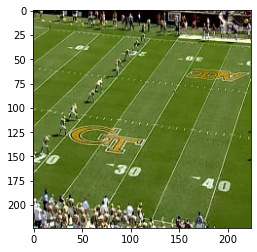

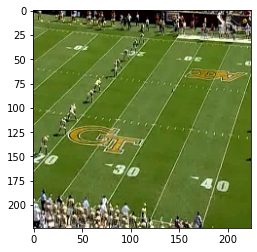

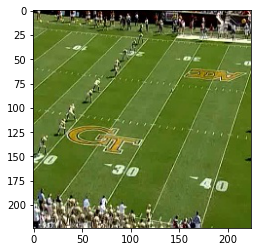

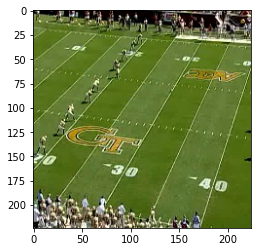

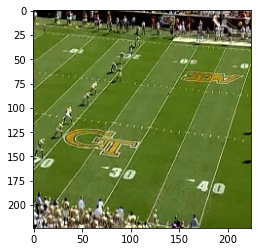

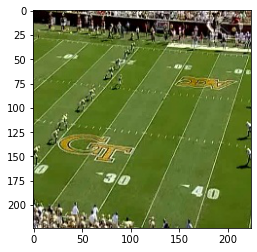

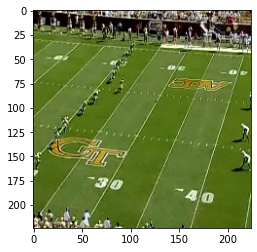

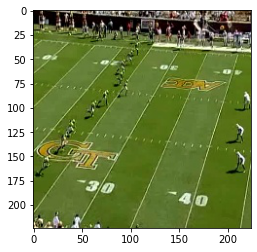

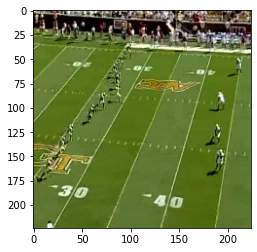

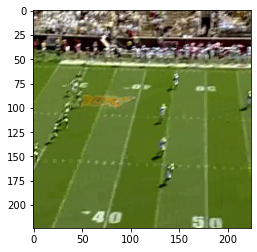

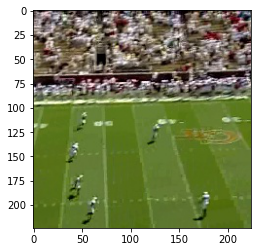

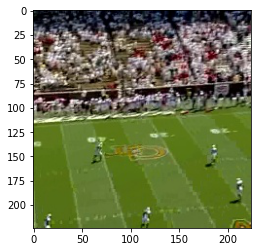

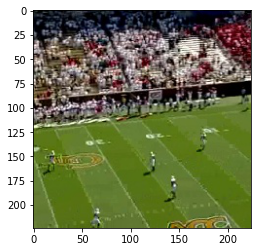

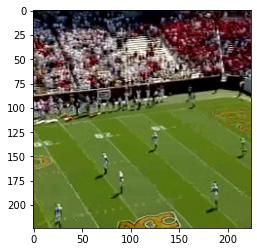

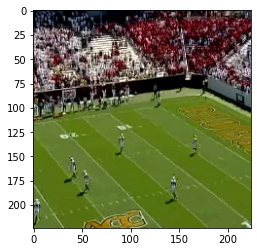

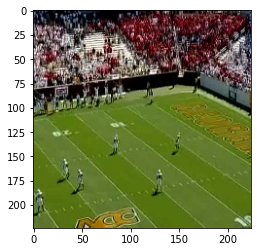

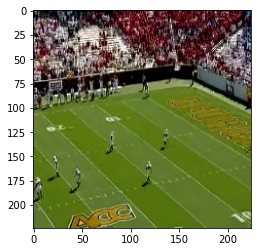

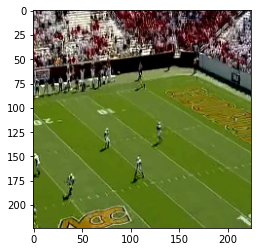

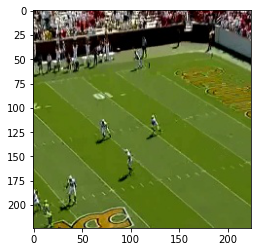

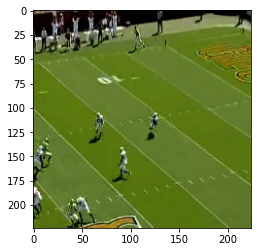

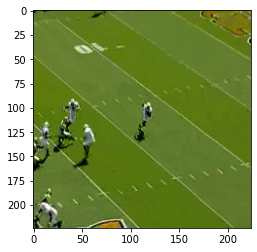

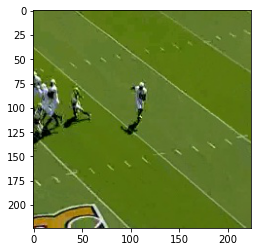

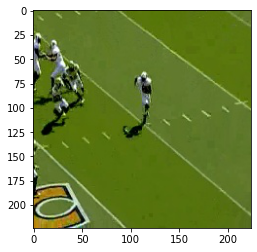

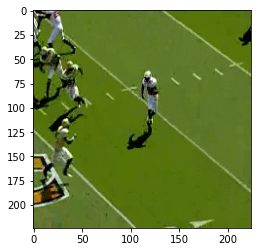

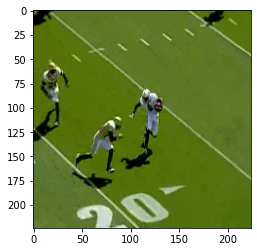

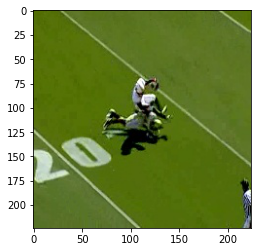

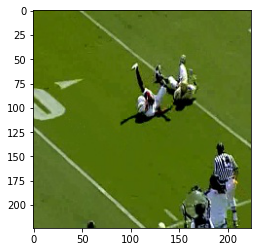

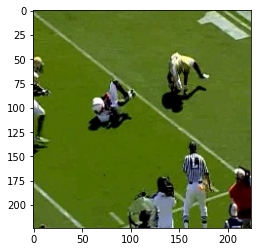

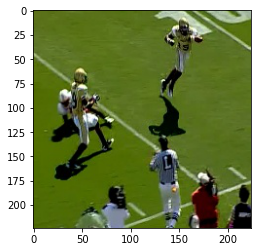

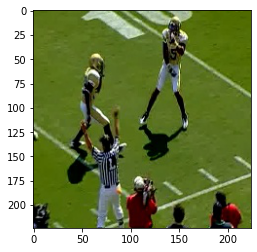

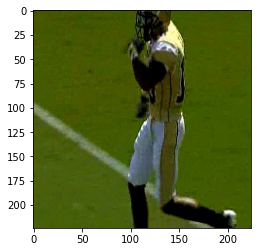

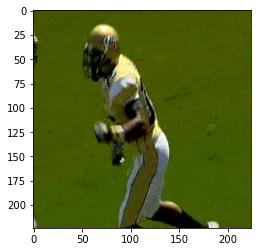

In [16]:
for i in range(len(images[0])):
    plt.figure()
    plt.imshow(images[0][i])